In [10]:
import os
import pandas as pd

directory = '../PruningProfiler/output/2024-04-18_Vaisakh/final'
dataframes = []

def process_model_perfstats(platform_type, modelname, filepath):
    # columns = ['metric', 'values']
    df = pd.read_csv(filepath+'/system_stats.csv')
    df.loc[len(df.index)] = ['modelname', modelname]
    df.loc[len(df.index)] = ['platform_type', platform_type]
    df = df.T
    df.columns = df.iloc[0]
    df.drop(df.index[0], inplace=True)
    # display(df)
    return df

combined_df = pd.DataFrame()
first_time = True
for filename in os.listdir(directory):
    # skip directories named as backup
    if filename == "backup":
        continue
    platform_type = filename
    for iterconfig_filename in os.listdir(os.path.join(directory, filename)):
        filepath = os.path.join(directory, filename, iterconfig_filename)
        ## We can use this for naming file or adding columns
        modelname, prune_conf, prune_ratio,batchsz,runnercnt = iterconfig_filename.split('-')
        # Get the "system_stats.csv" file and process it
        newdf = process_model_perfstats(platform_type, modelname, filepath)
        if first_time:
            combined_df = newdf
            first_time = False
        else:
            combined_df = pd.concat([combined_df, newdf])
print (len(combined_df.columns))
print (combined_df.columns)
newcols = ["platform_type", "modelname", 
           "prune_config", "prune_ratio",
            "batchsz_arg" , "num_workers_arg",
            "acc", 
            "chipset_name", "arch",
            #"l1_size", "l2_size", 
            #"cpuloadavg_1min", "cpuloadavg_5min", "cpu_psi_total", "io_psi_total",
            "vm_percent",# "swap_percent"
            ]
combined_df = combined_df[newcols]
combined_df = combined_df.sort_values(by = ['platform_type','modelname', 'prune_config', 'prune_ratio'], ascending=[True,True, True, True])
#pd.set_option('display.max_rows', 500)
display(combined_df)


21
Index(['vm_percent', 'swap_percent', 'cpuloadavg_1min', 'cpuloadavg_5min',
       'cpu_0', 'cpu_1', 'cpu_psi_total', 'mem_psi_total', 'io_psi_total',
       'acc', 'prune_config', 'prune_ratio', 'model_name', 'batchsz_arg',
       'num_workers_arg', 'chipset_name', 'arch', 'l1_size', 'l2_size',
       'modelname', 'platform_type'],
      dtype='object', name='Unnamed: 0')


Unnamed: 0,platform_type,modelname,prune_config,prune_ratio,batchsz_arg,num_workers_arg,acc,chipset_name,arch,vm_percent
0,Laptop,alexnet,l1_unstructured,0.0,32,4,55.400002002716064,Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz,x86_64,24.8
0,Laptop,alexnet,l1_unstructured,0.0,16,4,55.400002002716064,Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz,x86_64,24.85
0,Laptop,alexnet,l1_unstructured,0.0,16,2,55.400002002716064,Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz,x86_64,25.599999999999998
0,Laptop,alexnet,l1_unstructured,0.0,64,1,55.400002002716064,Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz,x86_64,25.76666666666667
0,Laptop,alexnet,l1_unstructured,0.0,8,2,55.400002002716064,Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz,x86_64,25.666666666666668
...,...,...,...,...,...,...,...,...,...,...
0,Server,vgg16,random_unstructured,0.7000000000000001,64,4,56.40000104904175,Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz,x86_64,1.5799999999999998
0,Server,vgg16,random_unstructured,0.7000000000000001,32,2,55.400002002716064,Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz,x86_64,1.5
0,Server,vgg16,random_unstructured,0.7000000000000001,128,4,58.60000252723694,Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz,x86_64,1.6
0,Server,vgg16,random_unstructured,0.7000000000000001,4,8,56.40000104904175,Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz,x86_64,1.54


In [11]:
import numpy as np
combined_df['IS_OOM'] = combined_df['acc'].apply(lambda x: True if x == 'NDF-OOM' else False)
combined_df['IS_OOM_int'] = combined_df['acc'].apply(lambda x: 2 if x == 'NDF-OOM' else (3 if x=='DNF-DATA_ERROR' else 1))
combined_df['corr_acc'] = combined_df['acc'].apply(lambda x: np.NaN if x == 'NDF-OOM' or x == 'DNF'  else float(x))
combined_df['prune_ratio'] = combined_df['prune_ratio'].apply(lambda x: float(x))

newdf = combined_df
#newdf = newdf.drop(columns=['OOM'])
newdf['corr_acc'].astype(float)
newdf['prune_ratio'].astype(float)
# newdf['IS_OOM_int'].astype(int)
newdf['batchsz_arg'].astype(int)
newdf['num_workers_arg'].astype(int)

newdf['High_Accuracy_Loss'] = newdf['corr_acc'].apply(lambda x: True if x < 50.0 else False)
newdf['High_Pruning'] = newdf['prune_ratio'].apply(lambda x: True if x > 0.3 else False)

# pd.set_option('display.max_rows', 5000)
display (newdf)

Unnamed: 0,platform_type,modelname,prune_config,prune_ratio,batchsz_arg,num_workers_arg,acc,chipset_name,arch,vm_percent,IS_OOM,IS_OOM_int,corr_acc,High_Accuracy_Loss,High_Pruning
0,Laptop,alexnet,l1_unstructured,0.0,32,4,55.400002002716064,Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz,x86_64,24.8,False,1,55.400002,False,False
0,Laptop,alexnet,l1_unstructured,0.0,16,4,55.400002002716064,Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz,x86_64,24.85,False,1,55.400002,False,False
0,Laptop,alexnet,l1_unstructured,0.0,16,2,55.400002002716064,Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz,x86_64,25.599999999999998,False,1,55.400002,False,False
0,Laptop,alexnet,l1_unstructured,0.0,64,1,55.400002002716064,Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz,x86_64,25.76666666666667,False,1,55.400002,False,False
0,Laptop,alexnet,l1_unstructured,0.0,8,2,55.400002002716064,Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz,x86_64,25.666666666666668,False,1,55.400002,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Server,vgg16,random_unstructured,0.7,64,4,56.40000104904175,Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz,x86_64,1.5799999999999998,False,1,56.400001,False,True
0,Server,vgg16,random_unstructured,0.7,32,2,55.400002002716064,Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz,x86_64,1.5,False,1,55.400002,False,True
0,Server,vgg16,random_unstructured,0.7,128,4,58.60000252723694,Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz,x86_64,1.6,False,1,58.600003,False,True
0,Server,vgg16,random_unstructured,0.7,4,8,56.40000104904175,Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz,x86_64,1.54,False,1,56.400001,False,True


In [12]:
training= newdf[[
            'platform_type', 
            'modelname', 
            'IS_OOM',
            #'IS_OOM_int',
            'corr_acc', 
            'batchsz_arg' , 
            'num_workers_arg',
            'prune_ratio',
            'High_Pruning',
            'High_Accuracy_Loss',
            # 'vm_percent'
            ]].copy()
pd.set_option('display.max_rows', 5000)
display(training)
training.to_csv('training.csv', index=False)

Unnamed: 0,platform_type,modelname,IS_OOM,corr_acc,batchsz_arg,num_workers_arg,prune_ratio,High_Pruning,High_Accuracy_Loss
0,Laptop,alexnet,False,55.400002,32,4,0.0,False,False
0,Laptop,alexnet,False,55.400002,16,4,0.0,False,False
0,Laptop,alexnet,False,55.400002,16,2,0.0,False,False
0,Laptop,alexnet,False,55.400002,64,1,0.0,False,False
0,Laptop,alexnet,False,55.400002,8,2,0.0,False,False
...,...,...,...,...,...,...,...,...,...
0,Server,vgg16,False,56.400001,64,4,0.7,True,False
0,Server,vgg16,False,55.400002,32,2,0.7,True,False
0,Server,vgg16,False,58.600003,128,4,0.7,True,False
0,Server,vgg16,False,56.400001,4,8,0.7,True,False


In [13]:
training.platform_type=training.platform_type.astype('category').cat.codes
training.modelname=training.modelname.astype('category').cat.codes
training.IS_OOM =training.IS_OOM.astype('category').cat.codes
training.High_Pruning =training.High_Pruning.astype('category').cat.codes
training.High_Accuracy_Loss =training.High_Accuracy_Loss.astype('category').cat.codes

training.batchsz_arg=training.batchsz_arg.astype(int)
training.num_workers_arg=training.num_workers_arg.astype(int)
training.dropna(inplace=True)
training = training.reset_index(drop=True)

labels = [f'{col}' for i, col in enumerate(training)]
data = training.to_numpy()

display(data)

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2. , 3. , 0. , ..., 0.7, 1. , 0. ],
       [2. , 3. , 0. , ..., 0.7, 1. , 0. ],
       [2. , 3. , 0. , ..., 0.7, 1. , 0. ]])

In [14]:
# from causallearn.search.ScoreBased.GES import ges

# # default parameters
# Record = ges(np.linalg.inv(data))

# # Visualization using pydot
# from causallearn.utils.GraphUtils import GraphUtils
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# import io

# pyd = GraphUtils.to_pydot(Record['G'], labels=labels)
# tmp_png = pyd.create_png(f="png")
# fp = io.BytesIO(tmp_png)
# img = mpimg.imread(fp, format='png')
# plt.axis('off')
# plt.imshow(img)
# plt.show()

/opt/anaconda/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  0%|          | 0/9 [00:00<?, ?it/s]

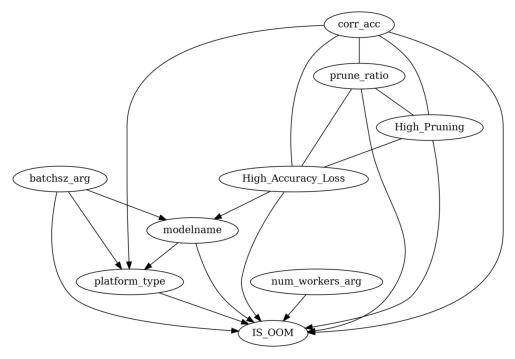

In [15]:
graphs = {}
graphs_nx = {}
labels = [f'{col}' for i, col in enumerate(labels)]
data = data

from causallearn.search.ConstraintBased.PC import pc

cg = pc(data)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(cg.G, labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

[2, 6, 5, 7, 8, 0, 1, 3, 4]
[[  0.           0.           0.           0.           0.
    0.           0.15651539   0.          -0.12864972]
 [  0.18067607   0.           0.           0.           0.
    0.           0.           0.          -0.0968872 ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  1.31907492  -0.78585261   0.           0.           0.
    0.         -20.79685917   6.6508534  -42.41280511]
 [  8.4111946   -4.02563559   0.          -0.09034575   0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           1.79035801   0.           0.        ]
 [  0.           0.           0.           0.           0.
 

/opt/anaconda/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


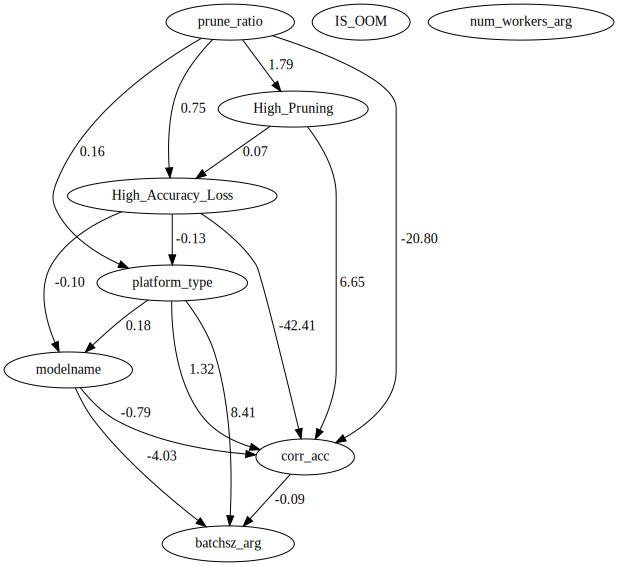

In [16]:
from causallearn.search.FCMBased import lingam


df1 = training[training.isna().any(axis=1)]
model = lingam.ICALiNGAM()
model.fit(training)
print(model.causal_order_)
print(model.adjacency_matrix_)

from causallearn.search.FCMBased.lingam.utils import make_dot
make_dot(model.adjacency_matrix_, labels=labels)